In [1]:
import os
import numpy as np
from imageio import imread
from scipy import linalg as la
from matplotlib import pyplot as plt

### Helper Functions

In [2]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

- Implement a `show()` function.
- Use `show()` to display a face from the `faces94` dataset.

In [3]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    image = np.reshape(image, (m,n)) # convert the flattened image to its original shape
    plt.imshow(image, cmap='gray') # plot the image in grayscale
    plt.axis('off')
    plt.show()

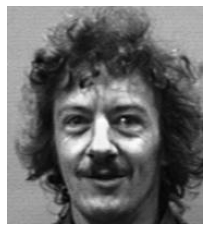

In [4]:
F = get_faces()
show(F[:,15])

In [5]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        self.F = get_faces() # create F
        
        # find the mean face (mu)
        sum_col = np.zeros_like(self.F[:,0])
        for i in range(0,self.F.shape[1]):
            sum_col += self.F[:,i]
        self.mu = sum_col / self.F.shape[1]
        
        # shift each file by mu to get Fbar
        self.Fbar = np.zeros_like(self.F)
        for i in range(0,self.F.shape[1]):
            self.Fbar[:,i] = self.F[:,i] - self.mu
        
        # get U from the compact svd
        self.U = la.svd(self.Fbar, full_matrices=False)[0]

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:,:s].T @ A # Matrix multiply U_s.T and A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        F_hat = self.project(self.F,s) # compute F_hat with self.project
        mu = self.mu
        g_bar = g - mu # shift g by the mean face
        g_hat = self.project(g,s) # compute g_hat with self.project
        
        new_F = (F_hat.T - g_hat).T # transpose F_hat to subtract nicely. Transpose result back to original F_hat dims
        matching_index = np.argmin(np.linalg.norm(new_F, axis=0)) # find column with smallest 2-norm
        
        return matching_index
        
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        # plotting the original input image
        image_show = np.reshape(image, (m,n))
        ax1 = plt.subplot(121)
        ax1.imshow(image_show, cmap='gray')
        ax1.axis('off')
        ax1.set_title("Input Image")
        
        # plotting the image from dataset that most closely matches input image
        new_image_show = np.reshape(self.F[:,self.find_nearest(image,s)], (m,n))
        ax2 = plt.subplot(122)
        ax2.imshow(new_image_show, cmap='gray')
        ax2.axis('off')
        ax2.set_title("Closest Match")
        
        return plt.show()
        
        
        

- In `FacialRec.__init__()`, compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
Store each as an attribute.

- Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

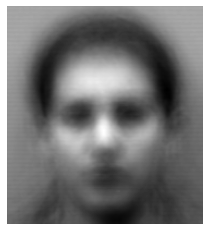

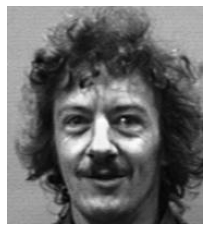

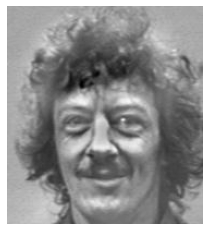

In [7]:
facial_rec = FacialRec()
show(facial_rec.mu) # mean face
show(facial_rec.F[:,15]) # original face
show(facial_rec.Fbar[:,15]) # mean-shifted face

- In `FacialRec.__init__()`, compute the compact SVD of $\bar{F}$ and store the $U$ as an attribute.
- Use `show()` to display some of the eigenfaces (the columns of $U$).
- Implement `FacialRec.project()` (in a single line).


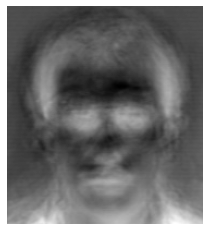

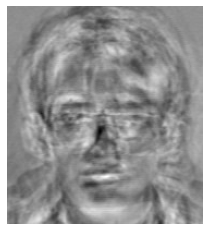

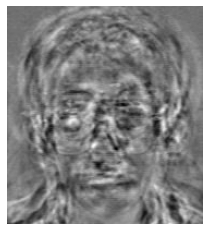

In [8]:
show(facial_rec.U[:,0]) # Eigenface at column 0
show(facial_rec.U[:,50])
show(facial_rec.U[:,100])

- Select one of the shifted images $\bar{\mathbf{f}}_i$.
- For 4 values of $s$, use `FacialRec.project()` to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- Display each of the reconstructions and the original image.

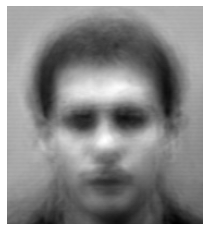

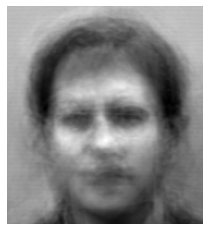

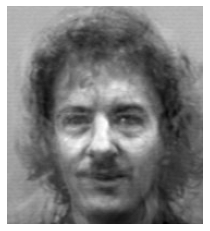

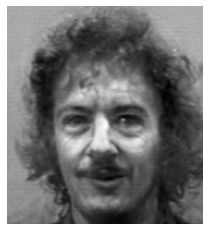

In [9]:
facial_rec = FacialRec()
test_face = facial_rec.F[:,15]
for s in [5,19,75,150]:
    projection = facial_rec.project(test_face,s)
    my_face = (facial_rec.U[:,:s] @ projection) + facial_rec.mu
    show(my_face)


- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

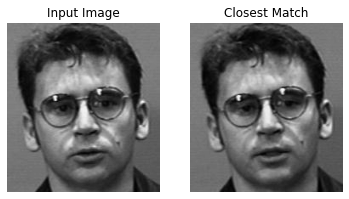

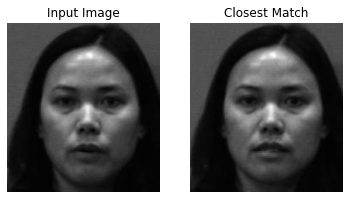

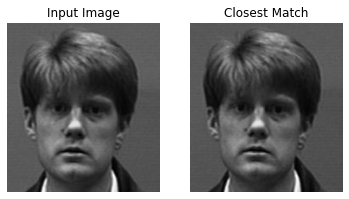

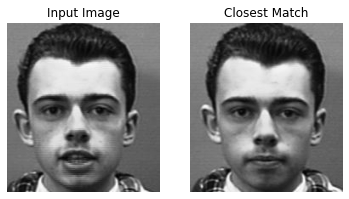

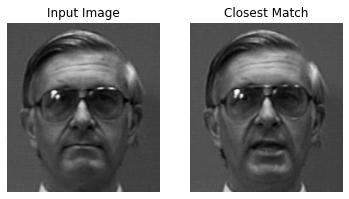

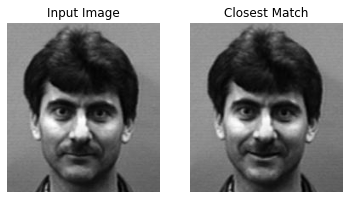

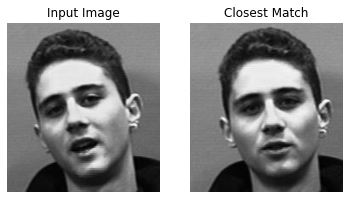

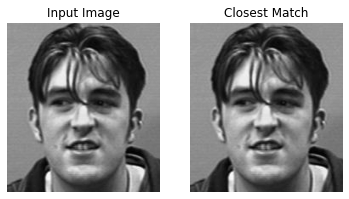

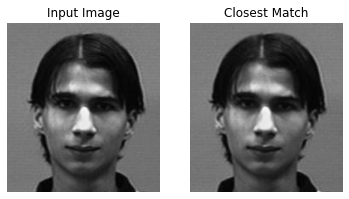

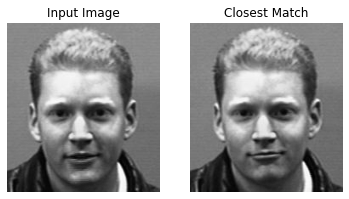

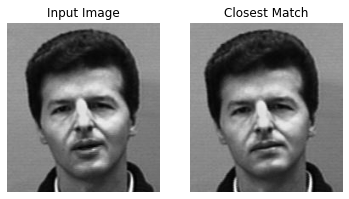

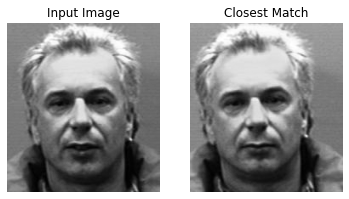

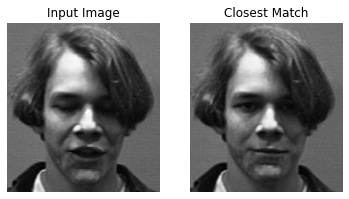

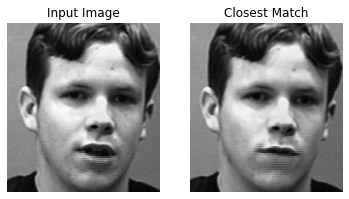

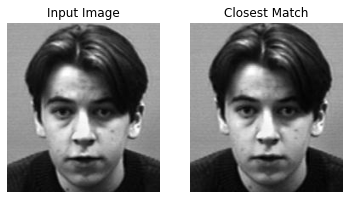

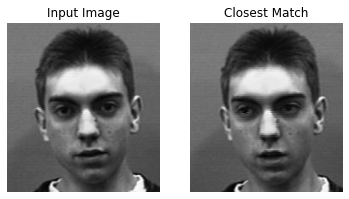

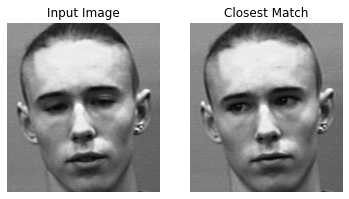

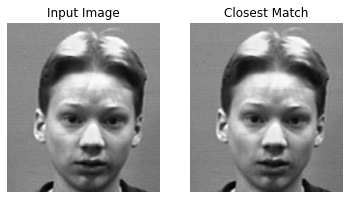

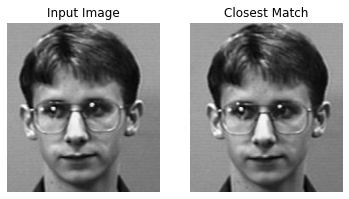

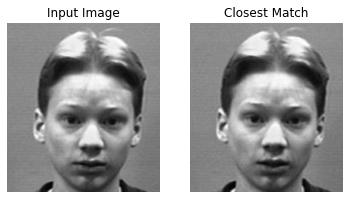

In [10]:
facial_rec = FacialRec()
faces = sample_faces(20)
for face in faces:
    facial_rec.match(face, s=38)